In [ ]:
!pip install tf-explain

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.image as mplimg
from matplotlib.pyplot import imshow
import zipfile as zf
import os
import csv
import gc
import operator
import random
from sklearn.model_selection import train_test_split
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from random import shuffle
from IPython.display import Image
from pathlib import Path

from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.utils import np_utils
import keras.backend as K
from keras.models import Sequential
from keras import optimizers

In [4]:
def load(path, size=128):
    img= cv2.resize(cv2.imread(path),(size,size))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def show():
    f, ax = plt.subplots(3, 5, figsize=(40,20))
    for i in tqdm(range(15)):
        path= os.path.join('../input/humpback-whale-identification/train', df_train.Image[i])
        img_id= df_train.Id[i]
        ax[i//5][i%5].imshow(load(path, 300), aspect='auto')
        ax[i//5][i%5].set_title(img_id)
        ax[i//5][i%5].set_xticks([]); ax[i//5][i%5].set_yticks([])
    plt.show()

def prepareImages(data, dataset):
#     print("Preparing images")
    X_train = np.zeros((data.shape[0], 100, 100, 3))
#     count = 0
    
    for idx, fig in tqdm(enumerate(data['Image'])):
        #load images into images of size 100x100x3
        img = image.load_img(dataset+"/"+fig, target_size=(100, 100, 3))
        x = image.img_to_array(img)
#         img = cv2.cvtColor(img , img , cv2.COLOR_RGBA2RGB)
#         x = ext_frgd(x)
#         x = preprocess_input(x)

        X_train[idx] = x
#         if (count%500 == 0):
#             print("Processing image: ", count+1, ", ", fig)
#         count += 1
    
    return X_train

def prepare_labels(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    # print(integer_encoded)

    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    # print(onehot_encoded)

    y = onehot_encoded
    # print(y.shape)
    return y, label_encoder

def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5

    return patched_image

def get_occ_map(model, CAT_CLASS_INDEX, img):
    PATCH_SIZE = 4

    sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

    # Iterate the patch over the image
    for top_left_x in tqdm(range(0, img.shape[0], PATCH_SIZE)):
        for top_left_y in range(0, img.shape[1], PATCH_SIZE):
            patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
#             plt.imshow(patched_image)
#             plt.show()
            predicted_classes = model.predict(np.array([patched_image]))[0]
            confidence = predicted_classes[CAT_CLASS_INDEX]

            # Save confidence for this specific patched image in map
            sensitivity_map[
                top_left_y:top_left_y + PATCH_SIZE,
                top_left_x:top_left_x + PATCH_SIZE,
            ] = confidence
    return sensitivity_map

In [5]:
# from sklearn.cluster import KMeans
# def k_means(img, n_colors= 4):
#     w, h, d = original_shape = tuple(img.shape)
#     img= img/255.0
#     image_array = np.reshape(img, (w * h, d))
#     kmeans = KMeans(n_clusters=n_colors, random_state=0).fit(image_array)
#     labels = kmeans.predict(image_array)
    
#     """Recreate the (compressed) image from the code book & labels"""
#     codebook= kmeans.cluster_centers_
#     d = codebook.shape[1]
#     image = np.zeros((w, h, d))
#     label_idx = 0
#     for i in range(w):
#         for j in range(h):
#             image[i][j] = codebook[labels[label_idx]]
#             label_idx += 1
#     return image

# def find_box(edges):
#     #contour masking
#     co, hi = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     con=max(co,key=cv2.contourArea)
#     conv_hull=cv2.convexHull(con)
    
#     top=tuple(conv_hull[conv_hull[:,:,1].argmin()][0])
#     bottom=tuple(conv_hull[conv_hull[:,:,1].argmax()][0])
#     left=tuple(conv_hull[conv_hull[:,:,0].argmin()][0])
#     right=tuple(conv_hull[conv_hull[:,:,0].argmax()][0])
    
#     return top, bottom, left, right

# def forgrd_ext(img, rec):
#     mask= np.zeros(img.shape[:2], np.uint8)
#     bgmodel= np.zeros((1, 65), np.float64)
#     fgmodel= np.zeros((1, 65), np.float64)
#     cv2.grabCut(img, mask, rec, bgmodel, fgmodel, 3, cv2.GC_INIT_WITH_RECT)
#     mask2= np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
#     img= img*mask2[:,:,np.newaxis]
#     img[np.where((img == [0,0,0]).all(axis = 2))] = [255.0, 255.0, 255.0]
#     return img

# def ext_frgd(df):
# #     f, ax = plt.subplots(5, 5, figsize=(40,30))
#     all_extr_imgs = []
#     for i in tqdm(range(df.shape[0])):
#         path= os.path.join('../input/humpback-whale-identification/train', df.Image[i])
#         img_id= df.Id[i]
#         img=load(path, 100)
#         org=img.copy()
#         img= k_means(img , n_colors= 10)
        
#         img_gray= cv2.cvtColor(np.uint8(img*255), cv2.COLOR_RGB2GRAY)
#         img_gray= cv2.medianBlur(img_gray,7)
#         edges = cv2.Canny(img_gray,100,200)
        
#         kernel= cv2.getStructuringElement(cv2.MORPH_RECT,(15,15))
#         edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
        
#         try:
#             top,bottom,left,right = find_box(edges)
#             rec= (left[0], top[1], right[0]-left[0], bottom[1]-top[1])
#             forground_img= forgrd_ext(org, rec)

#             all_extr_imgs.append(forground_img)
#         except:
#             continue
        
# #         ax[i//5][i%5].imshow(forground_img, aspect='auto')
# #         ax[i//5][i%5].set_title(img_id)
# #         ax[i//5][i%5].set_xticks([]); ax[i//5][i%5].set_yticks([])
# #     plt.show()
    
#     return all_extr_imgs
# # ext_frgd()

In [6]:
df = pd.read_csv('/kaggle/input/humpback-whale-identification/train.csv')
display(df.head())
print(df.shape)
df2 = df[df['Id']!='new_whale']
df2 = df2.groupby('Id').agg('count').rename({'Image': 'NumImages'}, axis=1)
df2.sort_values('NumImages', ascending=False, inplace=True)

NUM_IMAGES_THRESHOLD = 20

df3 = df2.query(f'NumImages > {NUM_IMAGES_THRESHOLD}')

print('shape:', df3.shape)
print('total number of images:', df3.NumImages.sum())
# df3
df_train = df[df['Id'].isin(np.array(df3.index))]
df_train = df_train.reset_index()
display(df_train.head())

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


(25361, 2)
shape: (59, 1)
total number of images: 1977


,index,Image,Id
0,26,004e8ad5b.jpg,w_3de579a
1,30,0052ce2f5.jpg,w_2365d55
2,32,00570db6b.jpg,w_9c506f6
3,52,008bf89fc.jpg,w_6822dbc
4,54,00910010d.jpg,w_700ebb4


In [7]:
from keras.preprocessing import image
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
X = np.load('../input/humpback-whales-foreground-extracted/images.npy')
X = X/255

y = np.load('../input/humpback-whales-foreground-extracted/labels.npy')
print("Shape Y-train: ", len(y))
print(X.shape)

Shape Y-train:  1972
(1972, 100, 100, 3)


In [8]:
X_tr = prepareImages(df_train, "../input/humpback-whale-identification/train")
X_tr /= 255

y_tr,le = prepare_labels(df_train['Id'])

1977it [00:36, 54.05it/s]


In [9]:
print("Shape Y-train: ", len(y_tr))
print(X_tr.shape)

Shape Y-train:  1977
(1977, 100, 100, 3)


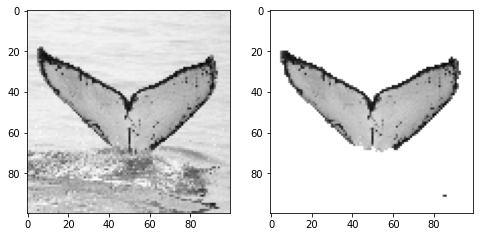

In [10]:
f, ax = plt.subplots(1, 2, figsize=(8,8))
ax[0].imshow(X_tr[0])
ax[1].imshow(X[0])
plt.show()

In [11]:
import tensorflow.keras as keras
from tensorflow.keras.applications import (DenseNet201,
                                           VGG19,
                                           VGG16,
                                           InceptionResNetV2,
                                           ResNet152V2)
from keras.layers import Dropout, Dense
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

In [16]:
def model_builder(model_val,INPUT_SHAPE):
    base_model = model_val(
        weights='imagenet',  # load weights pretrained on the ImageNet
        include_top=False,  # do not include the ImageNet classifier at the top
        input_shape=INPUT_SHAPE,
        pooling='max'  # add a global max pooling layer after the base model
    )
    base_model.trainable = True

    model = keras.Sequential([
        base_model,
        Dropout(0.2),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        # Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(59, name='predictions')
    ])
    return model
def train_funct(model):
    FINE_TUNING_EPOCHS = 50
    model.compile(optimizer=Adam(1e-3), 
                  loss=CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    fine_tuning_history = model.fit(X_tr,y_tr, 
                                    epochs=FINE_TUNING_EPOCHS,
                                    validation_split=0.2,
                                    verbose=1 
    )
    return model,fine_tuning_history

In [17]:
TARGET_SIZE = (100,100)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)
mod1 = model_builder(InceptionResNetV2, INPUT_SHAPE)

In [18]:
mod1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 1536)              54336736  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 512)               786944    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
predictions (Dense)          (None, 59)               

In [19]:
incep_res,_ = train_funct(mod1)

Epoch 1/50
50/50 [==============================] - 26s 204ms/step - loss: 4.0366 - accuracy: 0.0559 - val_loss: 4.9890 - val_accuracy: 0.0429
Epoch 2/50
50/50 [==============================] - 6s 127ms/step - loss: 3.2331 - accuracy: 0.1786 - val_loss: 3.2611 - val_accuracy: 0.2273
Epoch 3/50
50/50 [==============================] - 6s 129ms/step - loss: 2.4663 - accuracy: 0.3186 - val_loss: 2.6914 - val_accuracy: 0.2601
Epoch 4/50
50/50 [==============================] - 6s 129ms/step - loss: 1.9235 - accuracy: 0.4469 - val_loss: 2.6069 - val_accuracy: 0.3485
Epoch 5/50
50/50 [==============================] - 7s 130ms/step - loss: 1.3781 - accuracy: 0.6021 - val_loss: 2.4371 - val_accuracy: 0.4394
Epoch 6/50
50/50 [==============================] - 7s 131ms/step - loss: 1.0078 - accuracy: 0.6992 - val_loss: 1.9021 - val_accuracy: 0.5354
Epoch 7/50
50/50 [==============================] - 6s 129ms/step - loss: 0.6930 - accuracy: 0.7984 - val_loss: 2.1929 - val_accuracy: 0.5429
Epoch

In [40]:
sensitivity_map1= get_occ_map(incep_res, 15, X_tr[0])
sensitivity_map2 = get_occ_map(incep_res, 15, X[0])

100%|██████████| 25/25 [00:37<00:00,  1.48s/it]


In [21]:
def plot_occ_sensitivity_map(img,sensitivity_map):
    plt.imshow(img)
    plt.imshow(sensitivity_map,cmap='RdYlBu_r',alpha=0.5)
    plt.colorbar()
    plt.show()

In [45]:
def occ_sens_plot_both(img,img_fg,s1,s2):
    f, ax = plt.subplots(1, 2, figsize=(8,8))
    ax[0].imshow(img)
    ax[0].imshow(s1,cmap='RdYlBu_r',alpha=0.4)
#     plt.colorbar()
    ax[1].imshow(X[0])
    ax[1].imshow(s2,cmap='RdYlBu_r',alpha=0.4)
#     plt.colorbar()
    plt.show()

In [47]:
def plot_original():
    f, ax = plt.subplots(1, 2, figsize=(8,8))
    ax[0].imshow(X_tr[0])
    ax[1].imshow(X[0])
    plt.show()

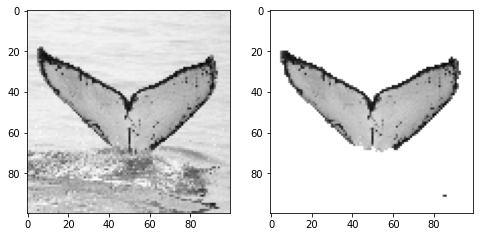

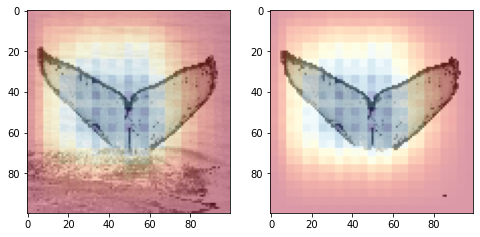

In [49]:
plot_original()
occ_sens_plot_both(X_tr[0],X[0],sensitivity_map1,sensitivity_map2)

In [ ]:
# layername='densenet201'
# conv_out = mod1.get_layer(layername).output
# from tensorflow.keras.models import Model
# gradmodel = Model(
#                    inputs=[mod1.inputs],
#                    ouputs=[conv_out,mod1.ouput])

In [ ]:
# tf.keras.applications.EfficientNetB7(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     **kwargs
# )

from tensorflow.keras.applications import DenseNet201
import keras
from keras.layers import Dropout, Dense
# Form the correct input shape for the model in case the `TARGET_SIZE` 
# is not square (e.g. (224, 224)).
TARGET_SIZE = (100,100)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

base_model = DenseNet201(
    weights='imagenet',  # load weights pretrained on the ImageNet
    include_top=False,  # do not include the ImageNet classifier at the top
    input_shape=INPUT_SHAPE,
    pooling='max'  # add a global max pooling layer after the base model
)
base_model.trainable = True

model = keras.Sequential([
    base_model,
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(59, name='predictions')
])
model.summary()

In [ ]:
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
FINE_TUNING_EPOCHS = 50

model.compile(optimizer=Adam(1e-5),  # set the learning rate to a low value
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tuning_history = model.fit(X_tr,y_tr, 
                                epochs=FINE_TUNING_EPOCHS,
                                validation_split=0.2,
                                verbose=1 #,  # don't display the progress bar
#                                 callbacks=callbacks
)

In [ ]:
# tf.keras.applications.EfficientNetB7(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
#     **kwargs
# )

from tensorflow.keras.applications import VGG19
import keras
from keras.layers import Dropout, Dense
# Form the correct input shape for the model in case the `TARGET_SIZE` 
# is not square (e.g. (224, 224)).
TARGET_SIZE = (100,100)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

base_model = VGG19(
    weights='imagenet',  # load weights pretrained on the ImageNet
    include_top=False,  # do not include the ImageNet classifier at the top
    input_shape=INPUT_SHAPE,
    pooling='max'  # add a global max pooling layer after the base model
)
base_model.trainable = True

model = keras.Sequential([
    base_model,
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(59, name='predictions')
])
model.summary()

from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
FINE_TUNING_EPOCHS = 50

model.compile(optimizer=Adam(1e-5),  # set the learning rate to a low value
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tuning_history = model.fit(X_tr,y_tr, 
                                epochs=FINE_TUNING_EPOCHS,
                                validation_split=0.2,
                                verbose=1 #,  # don't display the progress bar
#                                 callbacks=callbacks
)

In [ ]:
sensitivity_map = get_occ_map(model, 15, X_tr[0])

In [ ]:
plt.imshow(X_tr[0])
plt.imshow(sensitivity_map,cmap='RdYlBu_r',alpha=0.5)
plt.colorbar()

In [ ]:
sensitivity_map1 = get_occ_map(model, 15, X[0])

In [ ]:
plt.imshow(X[0])
plt.imshow(sensitivity_map1,cmap='RdYlBu_r',alpha=0.5)
plt.colorbar()

In [ ]:
from keras.applications.vgg16 import VGG16
import keras
from keras.layers import Dropout, Dense
# Form the correct input shape for the model in case the `TARGET_SIZE` 
# is not square (e.g. (224, 224)).
TARGET_SIZE = (100,100)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

base_model = VGG16(
    weights='imagenet',  # load weights pretrained on the ImageNet
    include_top=False,  # do not include the ImageNet classifier at the top
    input_shape=INPUT_SHAPE,
    pooling='max'  # add a global max pooling layer after the base model
)
base_model.trainable = True

model = keras.Sequential([
    base_model,
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(59, name='predictions')
])
model.summary()

In [ ]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# from tf_explain.callbacks.occlusion_sensitivity import OcclusionSensitivityCallback
# callbacks = [
#     OcclusionSensitivityCallback(
#         validation_data=(X_test, y_test),
#         class_index=0,
#         patch_size=4,
#         output_dir='./',
#     ),
# ]

In [ ]:
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
FINE_TUNING_EPOCHS = 50

model.compile(optimizer=Adam(1e-5),  # set the learning rate to a low value
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tuning_history = model.fit(X_tr,y_tr, 
                                epochs=FINE_TUNING_EPOCHS,
                                validation_split=0.2,
                                verbose=1 #,  # don't display the progress bar
#                                 callbacks=callbacks
)

In [ ]:
# # img = tf.keras.preprocessing.image.load_img(IMAGE_PATH, target_size=(224, 224))
# # img = tf.keras.preprocessing.image.img_to_array(img)
# data = ([X[0]], None)

# from tf_explain.core.grad_cam import GradCAM

# explainer = GradCAM()
# grid = explainer.explain(data, model, class_index=54)  # 281 is the tabby cat index in ImageNe

In [ ]:
model.predict_classes(np.array([X[0]]))

In [ ]:
np.argmax(y[0])

In [ ]:
import numpy as np
import tensorflow as tf

# Create function to apply a grey patch on an image
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size, :] = 127.5

    return patched_image

def get_occ_map(model, CAT_CLASS_INDEX, img):
    PATCH_SIZE = 4

    sensitivity_map = np.zeros((img.shape[0], img.shape[1]))

    # Iterate the patch over the image
    for top_left_x in tqdm(range(0, img.shape[0], PATCH_SIZE)):
        for top_left_y in range(0, img.shape[1], PATCH_SIZE):
            patched_image = apply_grey_patch(img, top_left_x, top_left_y, PATCH_SIZE)
#             plt.imshow(patched_image)
#             plt.show()
            predicted_classes = model.predict(np.array([patched_image]))[0]
            confidence = predicted_classes[CAT_CLASS_INDEX]

            # Save confidence for this specific patched image in map
            sensitivity_map[
                top_left_y:top_left_y + PATCH_SIZE,
                top_left_x:top_left_x + PATCH_SIZE,
            ] = confidence
    return sensitivity_map

In [ ]:
sensitivity_map = get_occ_map(model, 15, X_tr[0])

In [ ]:
y[1]

In [ ]:
sensitivity_map1 = get_occ_map(model, model.predict_classes(np.array([X[3]]))[0], X[0])

In [ ]:
model.predict(np.array([X[0]]))[0][15]

In [ ]:
plt.imshow(X_tr[0])

In [ ]:
sensitivity_map = get_occ_map(model, 15, X[0])

In [ ]:
plt.imshow(X[0])
plt.imshow(sensitivity_map,cmap='RdYlBu_r',alpha=0.5)
plt.colorbar()

In [ ]:
plt.imshow(X_tr[0])
plt.imshow(sensitivity_map,cmap='RdYlBu_r',alpha=0.5)
plt.colorbar()

In [ ]:
from keras.applications.vgg16 import VGG16
import keras
from keras.layers import Dropout, Dense
# Form the correct input shape for the model in case the `TARGET_SIZE` 
# is not square (e.g. (224, 224)).
TARGET_SIZE = (100,100)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

base_model = VGG16(
    weights='imagenet',  # load weights pretrained on the ImageNet
    include_top=False,  # do not include the ImageNet classifier at the top
    input_shape=INPUT_SHAPE,
    pooling='max'  # add a global max pooling layer after the base model
)
base_model.trainable = True

model = keras.Sequential([
    base_model,
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(59, name='predictions')
])
model.summary()

from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
FINE_TUNING_EPOCHS = 30

model.compile(optimizer=Adam(1e-5),  # set the learning rate to a low value
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tuning_history = model.fit(X,y, 
                                epochs=FINE_TUNING_EPOCHS,
                                validation_split=0.2,
                                verbose=1 #,  # don't display the progress bar
#                                 callbacks=callbacks
)

In [ ]:
# len(x)

In [ ]:
# plt.imshow(x[0])

In [ ]:
# df_train['Image'][0]

In [ ]:
from keras.layers import Dropout, Dense
TARGET_SIZE = (100,100)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

base_model_irnv2=tf.keras.applications.InceptionResNetV2(
    input_shape=INPUT_SHAPE,
    include_top=False,
    weights="imagenet",
    pooling='max'
)
base_model_irnv2.trainable = True

# model.summary()
irnv2_model = keras.Sequential([
    base_model_irnv2,
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(59, name='predictions')
])
irnv2_model.summary()

In [ ]:
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
FINE_TUNING_EPOCHS = 30

irnv2_model.compile(optimizer=Adam(1e-3),  # set the learning rate to a low value
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

irnv2_model_history = irnv2_model.fit(X,y, 
                                epochs=FINE_TUNING_EPOCHS,
                                validation_split=0.2,
                                verbose=1 #,  # don't display the progress bar
#                                 callbacks=callbacks
)

In [ ]:
sensitivity_map1 = get_occ_map(irnv2_model, irnv2_model.predict_classes(np.array([X[3]]))[0], X[0])
sensitivity_map = get_occ_map(irnv2_model, irnv2_model.predict_classes(np.array([X[0]]))[0], X[0])

In [ ]:
irnv2_model.predict_classes(np.array([X[0]]))

In [ ]:
irnv2_model.predict(np.array([X[0]]))[0][15]

In [ ]:
sensitivity_map[49]

In [ ]:
sensitivity_map1[49]

In [ ]:
plt.imshow(X[0])
plt.imshow(sensitivity_map1,cmap='RdYlBu_r',alpha=0.5)
plt.colorbar()

In [ ]:
plt.imshow(X[0])
plt.imshow(sensitivity_map,cmap='RdYlBu_r',alpha=0.5)
plt.colorbar()

In [ ]:

# plt.imshow(cv2.resize(cv2.cvtColor(cv2.imread("../input/humpback-whale-identification/train/"+df_train['Image'][0]), cv2.COLOR_BGR2RGB), (100, 100)))
# plt.imshow(sensitivity_map,cmap='RdYlBu_r',alpha=0.5)
# plt.colorbar()

In [ ]:
from keras.applications import ResNet152V2
import keras
from keras.layers import Dropout, Dense
# Form the correct input shape for the model in case the `TARGET_SIZE` 
# is not square (e.g. (224, 224)).
TARGET_SIZE = (100,100)
INPUT_SHAPE = (TARGET_SIZE[0], TARGET_SIZE[1], 3)

# tf.keras.applications.ResNet152V2(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=None,
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )

base_model = ResNet152V2(
    weights='imagenet',  # load weights pretrained on the ImageNet
    include_top=False,  # do not include the ImageNet classifier at the top
    input_shape=INPUT_SHAPE,
    pooling='max'  # add a global max pooling layer after the base model
)
base_model.trainable = True

# model.summary()
model = keras.Sequential([
    base_model,
    Dropout(0.2),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    # Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(59, name='predictions')
])
model.summary()

from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
FINE_TUNING_EPOCHS = 30

model.compile(optimizer=Adam(1e-3),  # set the learning rate to a low value
              loss=CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

fine_tuning_history = model.fit(X,y, 
                                epochs=FINE_TUNING_EPOCHS,
                                validation_split=0.2,
                                verbose=1 #,  # don't display the progress bar
#                                 callbacks=callbacks
)

In [ ]:
sensitivity_map1 = get_occ_map(model, model.predict_classes(np.array([X[3]]))[0], X[0])
sensitivity_map = get_occ_map(model, model.predict_classes(np.array([X[0]]))[0], X[0])

In [ ]:
plt.imshow(X[0])
plt.imshow(sensitivity_map1,cmap='RdYlBu_r',alpha=0.5)
plt.colorbar()

In [ ]:
plt.imshow(X[0])
plt.imshow(sensitivity_map,cmap='RdYlBu_r',alpha=0.5)
plt.colorbar()

In [ ]:
# model.predict(X[1:10])

In [ ]:
from PIL import Image
from matplotlib import cm
img1 = Image.fromarray(np.uint8(cm.gist_earth(X[0])*255))

In [ ]:
plt.imshow(X[0])

In [ ]:
plt.imshow(sensitivity_map)

cv2.merge([X[0][0],X[0][1],X[0][2]]).shape

In [ ]:
plt.plot(fine_tuning_history.history['accuracy'], label='train')
plt.plot(fine_tuning_history.history['val_accuracy'],label='validation')
plt.legend()

In [ ]:
mod = Sequential()

mod.add(Conv2D(512, (5, 5), strides = (1, 1), name = 'conv0', input_shape = (100, 100, 3)))
mod.add(Conv2D(512, (5, 5), strides = (1, 1), name = 'conv1'))
mod.add(BatchNormalization(axis = 3, name = 'bn0'))
mod.add(Activation('relu'))
mod.add(MaxPooling2D((2, 2), name='max_pool'))

mod.add(Conv2D(256, (5, 5), strides = (1, 1), name = 'conv2'))
mod.add(Conv2D(256, (5, 5), strides = (1, 1), name = 'conv3'))
mod.add(BatchNormalization(axis = 3, name = 'bn1'))
mod.add(Activation('relu'))
mod.add(MaxPooling2D((2, 2), name='max_pool1'))

mod.add(Conv2D(128, (5, 5), strides = (1, 1), name = 'conv4'))
mod.add(Conv2D(128, (5, 5), strides = (1, 1), name = 'conv5'))
mod.add(BatchNormalization(axis = 3, name = 'bn2'))
mod.add(Activation('relu'))
mod.add(MaxPooling2D((2, 2), name='max_pool2'))

mod.add(Conv2D(128, (3, 3), name = 'conv6'))
mod.add(Conv2D(128, (3, 3), name = 'conv7'))
mod.add(BatchNormalization(axis = 3, name = 'bn3'))
mod.add(Activation('relu'))
# mod.add(MaxPooling2D((2, 2), name='max_pool3'))
print(mod.output_shape)
# mod.add(Conv2D(128, (1, 1), name="conv8"))
# mod.add(Activation('relu'))
# mod.add(AveragePooling2D((2,2), name='avg_pool'))

mod.add(Flatten())
mod.add(Dense(500, activation="relu", name='rl'))
mod.add(Dropout(0.8))
mod.add(Dense(y.shape[1], activation='softmax', name='sm'))

print(mod.output_shape)

#opt = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
mod.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

history = mod.fit(X, y, epochs=25, verbose=1,validation_split=0.2)
gc.collect()

In [ ]:
sensitivity_map1 = get_occ_map(mod, mod.predict_classes(np.array([X[3]]))[0], X[0])
sensitivity_map = get_occ_map(mod, mod.predict_classes(np.array([X[0]]))[0], X[0])

In [ ]:
plt.imshow(X[0])
plt.imshow(sensitivity_map1,cmap='RdYlBu_r',alpha=0.5)
plt.colorbar()

In [ ]:
def load(path, size=128):
    img= cv2.resize(cv2.imread(path),(size,size))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
window= cv2.createCLAHE(clipLimit= 4.0, tileGridSize=(8, 8))
img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

ch1, ch2, ch3 = cv2.split(img_lab)
img_l = window.apply(ch1)
img_clahe = cv2.merge((img_l, ch2, ch3))

In [ ]:
f, ax = plt.subplots(1, 2, figsize=(18,20))
ax[0].imshow(img)
ax[1].imshow(cv2.cvtColor(img_clahe, cv2.COLOR_Lab2BGR))
plt.show()
color = ('b','g','r')
f, ax = plt.subplots(1, 2, figsize=(18,8))
for i,col in enumerate(color):
    histr = cv2.calcHist([img],[i],None,[256],[0,256])
    ax[0].plot(histr,color = col)
    plt.xlim([0,256])

for i,col in enumerate(color):
    histr = cv2.calcHist([img_clahe],[i],None,[256],[0,256])
    ax[1].plot(histr,color = col)
    plt.xlim([0,256])
    
plt.show()

In [ ]:
# for i in tqdm(range(df.shape[0])):
#     path= os.path.join('../input/humpback-whale-identification/train', df.Image[i])
#     load(path, size=128)
#     window= cv2.createCLAHE(clipLimit= 4.0, tileGridSize=(8, 8))
#     img_lab = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)

#     ch1, ch2, ch3 = cv2.split(img_lab)
#     img_l = window.apply(ch1)
#     img_clahe = cv2.merge((img_l, ch2, ch3))

In [ ]:
WORK_DIR = "../input/humpback-whale-identification"
label_col = "Id"
img_col = "Image"
train_folder = "train"
test_folder = "test"

In [ ]:
print('Train images: %d' %len(os.listdir(
    os.path.join(WORK_DIR, train_folder))))

In [ ]:
train_labels = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))
label_names = train_labels[label_col].value_counts().index
label_map = {name:i for (i,name) in enumerate(label_names)}
inv_label_map = {v: k for k, v in label_map.items()}

train_labels['label_name'] = train_labels[label_col].copy()
train_labels[label_col] = train_labels[label_col].map(label_map)
display(train_labels.head())

In [ ]:
import seaborn as sns

# Main parameters
BATCH_SIZE = 8
STEPS_PER_EPOCH = len(train_labels)*0.8 / BATCH_SIZE
VALIDATION_STEPS = len(train_labels)*0.2 / BATCH_SIZE
EPOCHS = 4
TARGET_SIZE = 512

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize = (6, 4))

for i in ['top', 'right', 'left']:
    ax.spines[i].set_visible(False)
ax.spines['bottom'].set_color('black')

sns.countplot(y = train_labels["label_name"], order=train_labels["label_name"].value_counts().index[:5], edgecolor = 'black',
              palette = reversed(sns.color_palette("viridis", 5)))
plt.xlabel('Classes', fontfamily = 'serif', size = 15)
plt.ylabel('Count', fontfamily = 'serif', size = 15)
plt.xticks(fontfamily = 'serif', size = 12)
plt.yticks(fontfamily = 'serif', size = 12)
ax.grid(axis = 'y', linestyle = '--', alpha = 0.9)
plt.show()



In [ ]:
df_train

In [ ]:
# df = pd.read_csv(os.path.join(WORK_DIR, "train.csv"))


In [ ]:
y.shape

In [ ]:
len(X),len(y)

In [ ]:
# np.save('./imgs.npy', X)

In [ ]:
# pip install tf-explain